In [32]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

In [33]:
### changes in physics - seasonal avg
sst_delta = 0.5 #change in SST, deg/yr?
mld_delta = 10 #change in MLD, m/yr
ot_delta = 5 # change in OT, Sv/yr (SV = 1e6 m3/s)

#### gradients in BGC
grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

### mean ecosystem parameters
mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
diatconc = 1 # mean diatom concentration (umol/L)
efratio = 0.5

### carbonate system variables
mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
mn_SST = 2 #(oC)
mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
mn_DIC = 2120 # (umol/L)
mn_TA = 2290 # (ueq/L)
mn_pCO2 = 380 # (ppm)

# conversions/ geography
PgC_mol = 1.2e-14 # pgC/mol
SO_area = 5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask


In [54]:
def effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area):
    
    dfco2 = mn_kg*0.04*mn_pCO2*sst_delta #dfCO2 = kg(4%-pCO2/degree x dSST)
    dfco2_pgCyr_SST = dfco2 * PgC_mol * SO_area #dfCO2 in PgC/yr

    return dfco2_pgCyr_SST

def effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_MLD_DIC = dfCO2_DIC * PgC_mol * SO_area 

    ##ta
    dfcCO2_TA = (-1/3)*dfCO2_DIC
    dfco2_pgCyr_MLD_TA = dfcCO2_TA * PgC_mol * SO_area 

    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dDIC_fe = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio#dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    print(dDIC_fe)
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_fe  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_MLD_Fe = dfCO2_Fe * PgC_mol * SO_area
    #print(dfco2_pgCyr_MLD_Fe)

    return dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe

def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio):

    dfco2_pgCyr_OT_DIC = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001*0.000000000000012 #dfCO2_DIC = dOverturning x (dDICv)
    dfco2_pgCyr_OT_TA = -(1/3)*dfco2_pgCyr_OT_DIC #dfCO2_TA = -1/3 x dfCO2_DIC
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dfco2_pgCyr_OT_Fe = dDICv * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012 # dfCO2_DIC = dOverturning x (dDIC)

    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe


def give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = False): 

    dfco2_pgCyr_SST  = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)

    dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = \
        effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area, grad_dFedz, dmudFe, mu_L, diatconc, efratio)

    dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
        effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio)
    
    CO2_SST = dfco2_pgCyr_SST
    CO2_MLD_phys_chem = dfco2_pgCyr_MLD_TA + dfco2_pgCyr_MLD_DIC
    CO2_OT_phys_chem = dfco2_pgCyr_OT_TA + dfco2_pgCyr_OT_DIC
    CO2_OT_MLD_bio = dfco2_pgCyr_OT_Fe + dfco2_pgCyr_MLD_Fe
    CO2_tot = CO2_SST + CO2_MLD_phys_chem + CO2_OT_phys_chem + CO2_OT_MLD_bio
    if verbose:
        
        print('individual effects')
        print(f'effect SST pgC/yr {dfco2_pgCyr_SST}')
        print(f'effect MLD (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_MLD_DIC}, {dfco2_pgCyr_MLD_TA}, {dfco2_pgCyr_MLD_Fe}')
        print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_Fe}')

        print('')
        print('--summary (in PgC/yr)')
        print(f'Change in CO2 flux due to SST change {CO2_SST}')
        print(f'Change in CO2 flux due to MLD change (combined physico-chemical effects) {CO2_MLD_phys_chem}')
        print(f'Change in CO2 flux due to Overturning change (combined physico-chemical effects) {CO2_OT_phys_chem}')
        print(f'Change in CO2 flux due to MLD+Overturning change (ecosystem effects) {CO2_OT_MLD_bio}')
        print(f'Total change in CO2 flux {CO2_tot}')

        return CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot

#         dfco2_pgCyr_SST = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)
#         dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area)


# Check duplication of CLQ's math in example problem 

In [55]:


dfco2_pgCyr_SST  = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)
print(f'effect SST pgC/yr {dfco2_pgCyr_SST}')
dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = \
    effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area, grad_dFedz, dmudFe, mu_L, diatconc, efratio)
print(f'effect MLD (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_MLD_DIC}, {dfco2_pgCyr_MLD_TA}, {dfco2_pgCyr_MLD_Fe}')
dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
    effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio)
print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_Fe}')

# dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc)
# print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_Fe}')

CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dfco2_pgCyr_OT_Fe, dfco2_pgCyr_MLD_Fe, CO2_tot = give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = True)


effect SST pgC/yr 0.3521232
-0.75424125
effect MLD (TA, DIC, Fe) pgC/yr 0.3255478641509434, -0.10851595471698113, -0.0876934385685849
effect OT (TA, DIC, Fe) pgC/yr 0.227232, -0.07574399999999999, -0.08161321319999999
-0.75424125
individual effects
effect SST pgC/yr 0.3521232
effect MLD (TA, DIC, Fe) pgC/yr 0.3255478641509434, -0.10851595471698113, -0.0876934385685849
effect OT (TA, DIC, Fe) pgC/yr 0.227232, -0.07574399999999999, -0.08161321319999999

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.3521232
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.21703190943396228
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.151488
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.1693066517685849
Total change in CO2 flux 0.5513364576653774


In [9]:

def make_yearlist(yrst, yrend, scen):
    
    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}cchem-param-medusa_scen-{scen}-{yr}.nc')
        ylist.append(t2[0])
        
    return ylist

ty_1A = make_yearlist(1950,2099,'1A')
ty_1B = make_yearlist(1950,2099,'1B')


In [13]:
td_1A = xr.open_mfdataset(ty_1A)
td_1B = xr.open_mfdataset(ty_1B)

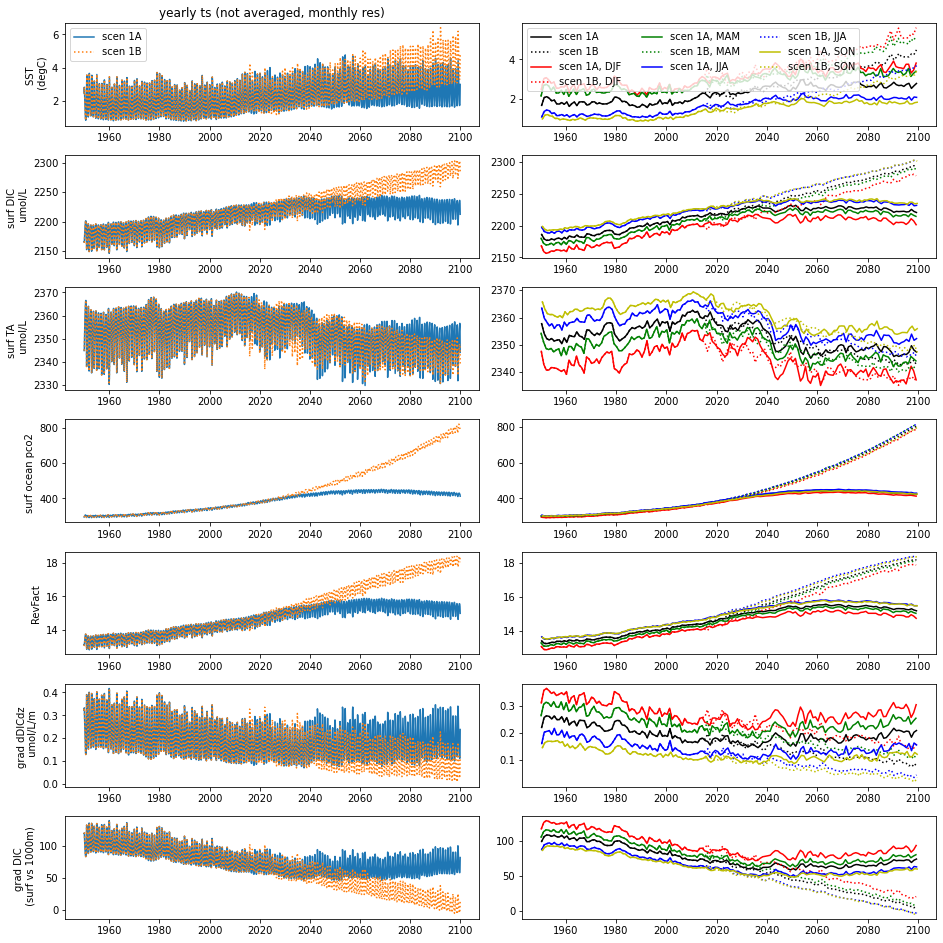

In [27]:
fact = 1.1
fig, axs = plt.subplots(7,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0*2].plot(td_1A.time_counter, td_1A.mn_SST.sel({'quantity': 'mean'}), label = 'scen 1A')
axs[1*2].plot(td_1A.time_counter, td_1A.mn_DIC.sel({'quantity': 'mean'}))
axs[2*2].plot(td_1A.time_counter, td_1A.mn_TA.sel({'quantity': 'mean'}))
axs[3*2].plot(td_1A.time_counter, td_1A.mn_pCO2.sel({'quantity': 'mean'}))
axs[4*2].plot(td_1A.time_counter, td_1A.mn_Revfact.sel({'quantity': 'mean'}))
axs[5*2].plot(td_1A.time_counter, td_1A.grad_dDICdz.sel({'quantity': 'mean'}))
axs[6*2].plot(td_1A.time_counter, td_1A.grad_DIC_surfdeep.sel({'quantity': 'mean'}))

axs[0*2].plot(td_1B.time_counter, td_1B.mn_SST.sel({'quantity': 'mean'}), linestyle = ':', label = 'scen 1B')
axs[1*2].plot(td_1B.time_counter, td_1B.mn_DIC.sel({'quantity': 'mean'}), linestyle = ':')
axs[2*2].plot(td_1B.time_counter, td_1B.mn_TA.sel({'quantity': 'mean'}), linestyle = ':')
axs[3*2].plot(td_1B.time_counter, td_1B.mn_pCO2.sel({'quantity': 'mean'}), linestyle = ':')
axs[4*2].plot(td_1B.time_counter, td_1B.mn_Revfact.sel({'quantity': 'mean'}), linestyle = ':')
axs[5*2].plot(td_1B.time_counter, td_1B.grad_dDICdz.sel({'quantity': 'mean'}), linestyle = ':')
axs[6*2].plot(td_1B.time_counter, td_1B.grad_DIC_surfdeep.sel({'quantity': 'mean'}), linestyle = ':')

axs[0].legend(loc = 'best')
ylabs = ['SST \n (degC)', 'surf DIC \n umol/L', 'surf TA \n umol/L', 'surf ocean pco2 ', 'RevFact ',\
        'grad dDICdz \n umol/L/m', 'grad DIC \n (surf vs 1000m)']
for i in range(0,7):
    axs[i*2].set_ylabel(ylabs[i])
axs[0].set_title('yearly ts (not averaged, monthly res)')


tvars = ['mn_SST','mn_DIC','mn_TA','mn_pCO2','mn_Revfact',\
       'grad_dDICdz','grad_DIC_surfdeep']
for i in range(0,7):
    
    axs[i*2+1].plot(td_1A.time_counter.groupby('time_counter.year').mean(),\
                    td_1A[tvars[i]].sel({'quantity': 'mean'}).groupby('time_counter.year').mean(),
                    color = 'k', label = 'scen 1A')
    axs[i*2+1].plot(td_1A.time_counter.groupby('time_counter.year').mean(),\
                    td_1B[tvars[i]].sel({'quantity': 'mean'}).groupby('time_counter.year').mean(),
                    color = 'k', linestyle = ':', label = 'scen 1B')
    cols = ['r','g','b','y']
    seas = ['DJF','MAM','JJA','SON']
    for c in range(0,4):
        axs[i*2+1].plot(td_1A.time_counter.sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                        .groupby('time_counter.year').mean(),\
                        td_1A[tvars[i]].sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                        .sel({'quantity': 'mean'}).groupby('time_counter.year').mean(),
                        color = cols[c], label = f'scen 1A, {seas[c]}')
        axs[i*2+1].plot(td_1A.time_counter.sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                        .groupby('time_counter.year').mean(),\
                        td_1B[tvars[i]].sel({'quantity': 'mean'}).sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                        .groupby('time_counter.year').mean(),
                        color = cols[c], linestyle = ':', label = f'scen 1B, {seas[c]}')
axs[1].legend(ncol = 3, fontsize = 10, loc = 'best')# bbox_to_anchor = [1,1])        
plt.tight_layout()

In [42]:
## trends in changes:
periodar =  ['1950-2000','2000-2050','2050-2100']
seasonar = ['FY','DJF','MAM','JJA','SON']
quantityar = ['wind','sst','mld','ot']
# quantityh = [wspd_t, sst_t, mld_t, ot_t]
forcingar = ['ghg','ozone']
scenarioar = ['ssp1','ssp3']
    
    
changes = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc')
changes

q = changes.trend.loc[{'period':'2050-2100', 'season':'DJF', 'quantity': 'sst', \
                      'forcing': 'ghg', 'scenario': 'ssp3' }] 
print(q)



<xarray.DataArray 'trend' ()>
array(0.345653)
Coordinates:
    period    <U9 '2050-2100'
    season    <U3 'DJF'
    quantity  <U3 'sst'
    forcing   <U3 'ghg'
    scenario  <U4 'ssp3'
Attributes:
    units:      /yr
    long_name:  


In [58]:
yr = 1950
td = td_1A.sel(time_counter=slice(f'{yr}-01-01', f'{yr+49}-12-31'))


<xarray.Dataset>
Dimensions:            (quantity: 4, time_counter: 600)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 1950-01-01 ... 1999-12-01
  * quantity           (quantity) object 'mean' 'stdev' 'max' 'min'
Data variables:
    grad_dDICdz        (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    grad_DIC_surfdeep  (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_kg              (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_SST             (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_Revfact         (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_DIC             (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_TA              (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
    mn_pCO2            (time_counter, quantity) float64 dask.array<chunksize=(12, 4), meta=np.ndarray>
Attributes:
    made in:  scratch/BOE-SOcarbon/extract_BOE_parameters_from_MEDUSA.py
    desc:

In [106]:
changes

<xarray.Dataset>
Dimensions:   (forcing: 2, period: 3, quantity: 4, scenario: 2, season: 5)
Coordinates:
  * period    (period) object '1950-2000' '2000-2050' '2050-2100'
  * season    (season) object 'FY' 'DJF' 'MAM' 'JJA' 'SON'
  * quantity  (quantity) object 'wind' 'sst' 'mld' 'ot'
  * forcing   (forcing) object 'ghg' 'ozone'
  * scenario  (scenario) object 'ssp1' 'ssp3'
Data variables:
    trend     (period, season, quantity, forcing, scenario) float64 ...
Attributes:
    made in:  SOZONE/windAnalyis/oceanFields/synthesisFigure.ipynb
    desc:     yearly medusa files, saving only variables of interest

In [111]:
verbose = True

datar = np.zeros([3,5,6,2,2])
data_vars = {'trend':(['period', 'season', 'quantity', 'forcing','scenario'], datar,
{'units': '/yr',
'long_name':''}),
}
# define coordinates
coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
          'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
          'quantity': (['quantity'], ['CO2_SST','CO2_MLD_phys_chem',\
                                      'CO2_OT_phys_chem','CO2_MLD_bio',\
                                      'CO2_OT_bio','CO2_tot']),
          'forcing': (['forcing'], ['ghg','ozone']),
          'scenario': (['scenario'], ['ssp1','ssp3']),
          
         }
attrs = {'made in':'SOZONE/windAnalyis/oceanFields/synthesisFigure.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)

#ds.sel(period='1950-2000', season='fy', quantity = 'sst', forcing = 'ghg').data = 10
ds.trend.loc[{'period':'1950-2000', 'season':'FY', \
              'quantity':'CO2_SST', 'forcing' : 'ghg', 'scenario' : 'ssp1'}] = 0

periodar =  ['1950-2000','2000-2050','2050-2100']
psta = [1950,2000,2050]; pen = [2000,2050,2100]
seasonar = ['FY','DJF','MAM','JJA','SON']
mu_L_ar = [0.5, 0, 0.5, 1, 0.5]
diatar = [0.5, 1, 0.5, 0, 1]

forcingar = ['ghg','ozone']
scenarioar = ['ssp1','ssp3']

for p in periodar:
    ind = 0 
    tpe = int(p[0:4])
    for s in seasonar:
        diatconc = (diatar[ind])
        mu_L = mu_L_ar[ind]
        if verbose:
            print(f'diatoms {diatconc}, mu_L {mu_L}')
        ind = ind+1
        for f in forcingar:
            for sc in scenarioar:
                
                sst_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                  'forcing': f, 'scenario': sc }].values *0.1  
                mld_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                  'forcing': f, 'scenario': sc }].values*0.1  
                ot_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                  'forcing': f, 'scenario': sc }].values *0.1 
                if verbose:
                    print(f'{p} (starts ({tpe}), {s}, {f}, {sc}, {sst_t}, {mld_t}, {ot_t}')
                
                if np.isnan(sst_t): sst_t = 0
                if np.isnan(mld_t): mld_t = 0
                if np.isnan(ot_t): ot_t = 0
                    
                if sc == 'ssp1': td = td_1A;
                if sc == 'ssp3': td = td_1B;
                td = td.sel(time_counter=slice(f'{tpe}-01-01', f'{tpe+49}-12-31'))

                if s == 'FY':
                    td = td.groupby('time_counter.year').mean()
                else:
                    td = td.sel(time_counter=(td['time_counter.season'] == s)).\
                    groupby('time_counter.year').mean()

                mn_kg = 0.065; mn_pCO2 = td.mn_pCO2[:,0].mean().values; sst_delta = sst_t; 
                PgC_mol = 1.2e-14 # pgC/mol 
                SO_area = 5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask
                mld_delta = mld_t; grad_dDICdz = td.grad_dDICdz[:,0].mean().values;
                mn_Revfact = td.mn_Revfact[:,0].mean().values; 
                grad_DIC_surfdeep = td.grad_DIC_surfdeep[:,0].mean().values;
                mn_DIC = td.mn_DIC[:,0].mean().values; ot_delta = ot_t;
                
                if verbose:
                    print(mn_DIC)
#                 dmudFe = 0
#                 mu_L = 
#                 diatconc = 
#                 grad_dFev = 
#                 efratio = 

                grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
                grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)
                ### mean ecosystem parameters
                dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
                efratio = 0.5
                
                
                CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,\
                dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot =\
                give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = verbose)
                
    
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                  'forcing': f, 'scenario': sc }] = CO2_SST
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                  'forcing': f, 'scenario': sc }] = CO2_OT_phys_chem
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                  'forcing': f, 'scenario': sc }] = CO2_MLD_phys_chem
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                  'forcing': f, 'scenario': sc }] = dfco2_pgCyr_MLD_Fe
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                  'forcing': f, 'scenario': sc }] = dfco2_pgCyr_OT_Fe
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                  'forcing': f, 'scenario': sc }] = CO2_tot



                if verbose:
                    print()
                    print()


diatoms 0.5, mu_L 0.5
1950-2000 (starts (1950), FY, ghg, ssp1, nan, -0.06402505681357162, nan
2189.1437477174004
0.001207258472059732
individual effects
effect SST pgC/yr 0.0
effect MLD (TA, DIC, Fe) pgC/yr -0.0013100935067247256, 0.0004366978355749085, 0.00010984492168317326
effect OT (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.0
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.000873395671149817
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.0
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.00010984492168317326
Total change in CO2 flux -0.0007635507494666438


1950-2000 (starts (1950), FY, ghg, ssp3, nan, -0.06402505681357162, nan
2189.1437477174004
0.001207258472059732
individual effects
effect SST pgC/yr 0.0
effect MLD (TA, DIC, Fe) pgC/yr -0.0013100935067247256, 0.0004366978355749085, 0.00010984492168317326
effect OT (TA, DIC, Fe) pgC/yr 0.0,

2199.940099368132
-0.0
individual effects
effect SST pgC/yr 0.0
effect MLD (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0
effect OT (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.0
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.0
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.0
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.0
Total change in CO2 flux 0.0


1950-2000 (starts (1950), JJA, ghg, ssp3, nan, nan, nan
2199.940099368132
-0.0
individual effects
effect SST pgC/yr 0.0
effect MLD (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0
effect OT (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.0
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.0
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.0
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 

2208.3807163692
-0.0
individual effects
effect SST pgC/yr 0.008668015518146327
effect MLD (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0
effect OT (TA, DIC, Fe) pgC/yr 0.002214030469271721, -0.0007380101564239069, -0.0

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.008668015518146327
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.0
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.001476020312847814
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.0
Total change in CO2 flux 0.01014403583099414


2000-2050 (starts (2000), DJF, ozone, ssp1, 0.01077774353474524, -0.09951562099674251, nan
2205.208324737206
0.0
individual effects
effect SST pgC/yr 0.007676498940524962
effect MLD (TA, DIC, Fe) pgC/yr -0.0028559654831768156, 0.0009519884943922718, 0.0
effect OT (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.007676498940524962
Change in CO2 flux due to ML

2231.3583723452434
-0.0
individual effects
effect SST pgC/yr 0.005031883948693183
effect MLD (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0
effect OT (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.005031883948693183
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.0
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.0
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.0
Total change in CO2 flux 0.005031883948693183


2000-2050 (starts (2000), SON, ozone, ssp3, 0.00572493922044439, nan, nan
2234.849934771431
-0.0
individual effects
effect SST pgC/yr 0.004253976848471523
effect MLD (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0
effect OT (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.004253976848471523
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.0
Change in CO2 flux due to Overturning change (comb

2236.53348441077
-0.0
individual effects
effect SST pgC/yr 0.0019472743918671482
effect MLD (TA, DIC, Fe) pgC/yr 0.001420521449879601, -0.00047350714995986697, -0.0
effect OT (TA, DIC, Fe) pgC/yr -0.0019161231103244024, 0.0006387077034414675, 0.0

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.0019472743918671482
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.0009470142999197339
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.001277415406882935
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.0
Total change in CO2 flux 0.0016168732849039472


2050-2100 (starts (2050), JJA, ghg, ssp3, 0.02908629218556276, -0.08376210025630543, nan
2278.4202133888743
0.0
individual effects
effect SST pgC/yr 0.03471074585659514
effect MLD (TA, DIC, Fe) pgC/yr -0.0011981101760748828, 0.0003993700586916276, 0.0
effect OT (TA, DIC, Fe) pgC/yr 0.0, -0.0, -0.0

--summary (in PgC/yr)
Change in CO2 flux due to SST

In [114]:
ds

<xarray.Dataset>
Dimensions:   (forcing: 2, period: 3, quantity: 6, scenario: 2, season: 5)
Coordinates:
  * period    (period) <U9 '1950-2000' '2000-2050' '2050-2100'
  * season    (season) <U3 'FY' 'DJF' 'MAM' 'JJA' 'SON'
  * quantity  (quantity) <U17 'CO2_SST' 'CO2_MLD_phys_chem' ... 'CO2_tot'
  * forcing   (forcing) <U5 'ghg' 'ozone'
  * scenario  (scenario) <U4 'ssp1' 'ssp3'
Data variables:
    trend     (period, season, quantity, forcing, scenario) float64 0.0 ... 0.0
Attributes:
    made in:  SOZONE/windAnalyis/oceanFields/synthesisFigure.ipynb
    desc:     yearly medusa files, saving only variables of interest

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


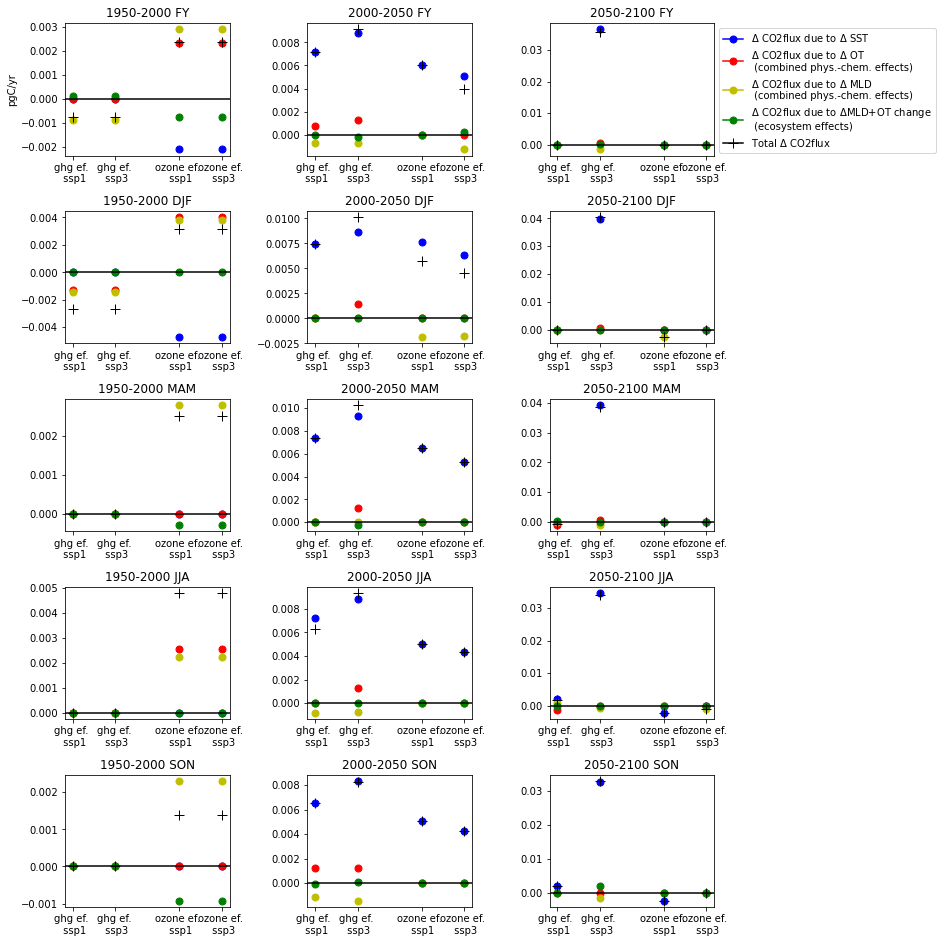

In [141]:
fact = 1.1
fig, axs = plt.subplots(5,3, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
seasonar = ['FY','FY','FY',\
            'DJF','DJF','DJF',\
            'MAM', 'MAM', 'MAM',\
            'JJA','JJA','JJA',\
            'SON','SON','SON']
periodar = ['1950-2000','2000-2050','2050-2100']
for i in range(0,15):
    
    per = i%3
    p = periodar[per]
    s = seasonar[i]
    fs = ['ghg','ghg','ozone','ozone'];
    scs = ['ssp1','ssp3','ssp1','ssp3']
    inds = [1,2,3.5,4.5]
    for x in range(4):
        f = fs[x]; sc = scs[x]; ind = inds[x]
        CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]
        CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 
        CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 
        CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 
        CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]
        CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 
        
        ms = 7
        if ind ==1:
            axs[i].plot(ind,CO2_SST,marker = 'o', markersize = ms, color = 'b',\
                        label = '$\Delta$ CO2flux due to $\Delta$ SST')
            axs[i].plot(ind,CO2_OT_phys_chem,marker = 'o', markersize = ms, color = 'r',\
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)')    
            axs[i].plot(ind,CO2_MLD_phys_chem,marker = 'o', markersize = ms, color = 'y',\
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
            axs[i].plot(ind,CO2_MLD_bio+CO2_OT_bio,marker = 'o', markersize = ms, color = 'green',\
                        label = '$\Delta$ CO2flux due to $\Delta$MLD+OT change \n (ecosystem effects)')  
            axs[i].plot(ind,CO2_tot,marker = '+', markersize = ms+3, color = 'k',\
                        label = 'Total $\Delta$ CO2flux') 
        else:
            axs[i].plot(ind,CO2_SST,marker = 'o', markersize = ms, color = 'b',\
                        )
            axs[i].plot(ind,CO2_OT_phys_chem,marker = 'o', markersize = ms, color = 'r',\
                        )    
            axs[i].plot(ind,CO2_MLD_phys_chem,marker = 'o', markersize = ms, color = 'y',\
                        )   
            axs[i].plot(ind,CO2_MLD_bio+CO2_OT_bio,marker = 'o', markersize = ms, color = 'green',\
                        )  
            axs[i].plot(ind,CO2_tot,marker = '+', markersize = ms+3, color = 'k',\
                        )  
    axs[2].legend(bbox_to_anchor = [1,1], fontsize = 10)
    
    axs[i].set_xticks([1,2,3.5,4.5])
    axs[i].set_xticklabels(['ghg ef. \n ssp1','ghg ef. \n ssp3','ozone ef. \n ssp1','ozone ef. \n ssp3'])
    axs[i].set_title(f'{p} {s}')
    axs[0].set_ylabel('pgC/yr')
    axs[i].axhline(y=0, color = 'k')
    
    plt.tight_layout()

In [97]:
w = td.mn_SST[:,0].mean().values
print(w)

1.8116605089662374


In [8]:
test = False
if test:
    
    sst_delta = 0.01 #change in SST, deg/yr?
    mld_delta = 1 #change in MLD, m/yr
    ot_delta = 0.02 # change in OT, Sv/yr (SV = 1e6 m3/s)

    #### gradients in BGC
    grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
    grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
    grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
    grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

    ### mean ecosystem parameters
    mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
    dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
    diatconc = 1 # mean diatom concentration (umol/L)

    ### carbonate system variables
    mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
    mn_SST = 2 #(oC)
    mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
    mn_DIC = 2120 # (umol/L)
    mn_TA = 2290 # (ueq/L)
    mn_pCO2 = 380 # (ppm)


    yr = 1950
    nam = f'test-{yr}.nc'
    times = pd.date_range(f"{yr}/01/01",f"{yr}/12/11",freq='MS')#,closed='left')
    print(times)
    data_vars = {
        'sst_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                 {'units': ''}),                       
       'mld_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

        'sst_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mld_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

        'sst_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mld_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### bgc gradients
        'grad_dDICdz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_dFedz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_dFev': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'dmudFe': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'diatconc': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_SST': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_Revfact': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_DIC': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_TA': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_pCO2': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),




    }

    coords = {'time_counter': (['time_counter'], times),
              'quantity': (['mean', 'stdev', 'max', 'min']),
            #   'stdev': (['stdev'], 'stdev'),
            #   'max': (['max'], 'max'),
            #   'min': (['min'], 'min'),


    }
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/sketch.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
# ds.to_netcdf(savenam)